In [2]:
import sys
import os
import numpy as np
import pickle as pkl
from sklearn import decomposition, ensemble, model_selection, cluster
from matplotlib import pyplot as plt
import pandas as pd
import importlib

cwd = os.getcwd()
cwd = cwd[: -(1 + len(cwd.split("/")[-1]))] + "/neuronencodings"
sys.path.append(cwd)

HOME = os.path.expanduser("~")

/usr/people/svenmd/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import pred

Deprecation Warning: /usr/people/svenmd/.cloudvolume/secrets/google-secret.json is now preferred to /secrets/google-secret.json.
Deprecation Warning: /usr/people/svenmd/.cloudvolume/secrets/google-secret.json is now preferred to /secrets/google-secret.json.
Deprecation Warning: /usr/people/svenmd/.cloudvolume/secrets/aws-secret.json is now preferred to /secrets/aws-secret.json.


## Cell ground truth

From Ashwin. 7 = orphan axons, 6 has high Axon ratio, 1-6 are different cell types. Focus actually is on 7 (finding subtypes).

In [4]:
cell_type_exs = {"1": [76631, 76700, 76656, 76655, 76660, 76679, 77393, 77395, 77375, 
                       77815, 77803, 77807, 77445, 77328, 77255],
                 "2": [78046, 78049, 78048, 78047, 78050, 78051],
                 "3": [77125, 77128, 77135, 77153, 77231, 77247, 78685, 77941, 77137, 
                       79053], 
                 "4": [77631, 77150, 77618, 77886, 78547, 77158, 78556, 78552, 77665,
                       77668, 77634],
                 "5": [77154, 77646, 77682, 77628, 77295, 77297, 77652, 77292, 77688, 
                       77654, 77658, 77657, 77662, 77296],
                 "6": [77483, 77484, 77485, 77486, 77487, 77488, 77489, 77490],
                 "7": [76775, 76776, 76782, 76666, 76693, 76781, 76774, 76675, 76621, 
                       76619, 76670, 76681, 76674, 77392, 77348, 77370, 77358]}

cell_types = np.array(list(cell_type_exs.keys()))

## Load model

In [31]:
expt_name = "fish_local_ae_v3"
model_name = "PointNetAE"
chkpt = 55000
batch_size = 10
bn = True
n_points = 250

In [32]:
model = pred.load_model(expt_name, model_name, chkpt, bn=bn, n_points=n_points, bottle_fs=64, eval_=True)

In [33]:
model

PointNetAE(
  (mlp1): ConvMLP(
    (conv1): Conv1d(3, 512, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool1d(kernel_size=250, stride=250, padding=0, dilation=1, ceil_mode=False)
  (mlp2): LinearMLP(
    (layer1): Linear(in_features=64, out_features=384, bias=False)
    (bn1): BatchNorm1d(3

## Load dataset

In [34]:
all_ids = []
for ids in cell_type_exs.values():
    all_ids.extend(ids)

In [35]:
dataset = pred.load_orphans(dataset_name="fish")

In [36]:
base_path = os.path.dirname(dataset.gt_files[0])
path_dict = {}
for c_id in all_ids:
    path = base_path + "/%d_m.obj" % c_id
    if path in dataset.gt_files:
        path_dict[c_id] = path

## Plotting

In [37]:
cm = plt.get_cmap('tab10')

In [38]:
colors = [cm(.05 + .1 * i) for i in range(10)]

In [39]:
def pca_plot_cell_types(preds, infos, n_components=10, plot_axis=[[0, 1], [2, 3]]):
    features_n = preds.copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=n_components)
    features_t = pca.fit_transform(features_n)

    for axis in plot_axis:
        plt.figure(figsize=(10, 10))
        # plt.scatter(features_t[:, 0], features_t[:, 1], alpha=.5, c=".2")

        cell_ids = []
        cell_labels = []
        for i_ct, ct in enumerate(cell_types):
            m = np.in1d(infos[:, 0], cell_type_exs[ct])

            print(ct, np.sum(m), len(cell_type_exs[ct]))

            plt.scatter(features_t[m, axis[0]], features_t[m, axis[1]], label=ct, c=colors[i_ct], alpha=.7)
            plt.scatter(np.mean(features_t[m, axis[0]]), np.mean(features_t[m, axis[1]]), c=colors[i_ct], alpha=.7, lw=20)

            cell_ids.extend(np.where(m)[0])
            cell_labels.extend([ct] * np.sum(m))

        plt.xlabel("PC %d" % (axis[0] + 1), fontsize=16)
        plt.ylabel("PC %d" % (axis[1] + 1), fontsize=16)

        plt.legend(fontsize=16, frameon=False)
        plt.show()

# nuno_basket_ids = np.array(nuno_basket_ids)
# nuno_basket_labels = np.array(nuno_basket_labels)

## Prediction

In [40]:
importlib.reload(pred)

<module 'pred' from '/usr/people/svenmd/NeuronEncodings/neuronencodings/pred.py'>

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


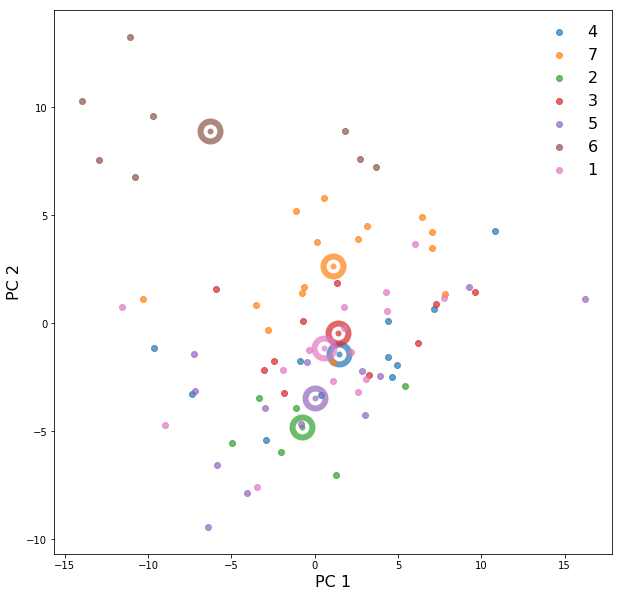

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


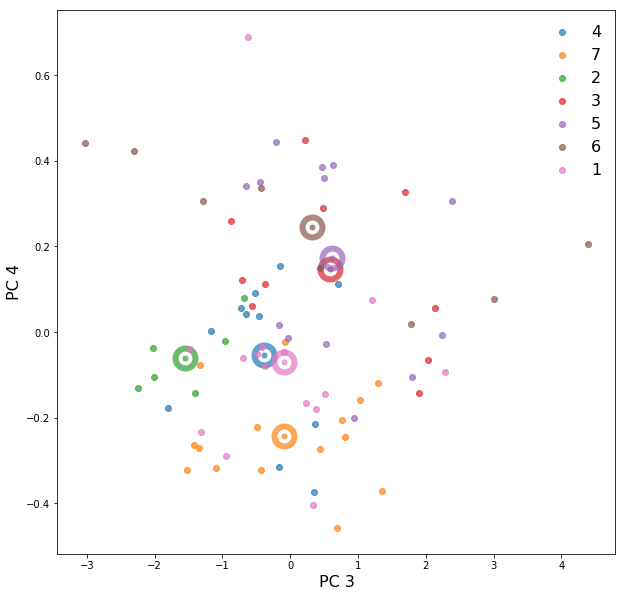

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


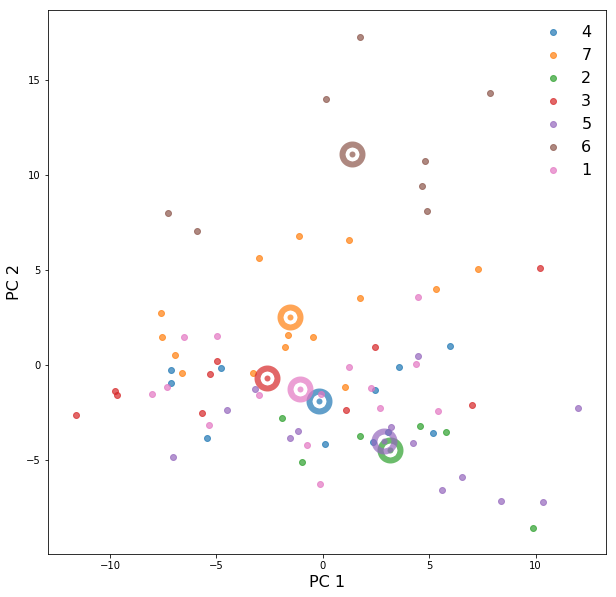

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


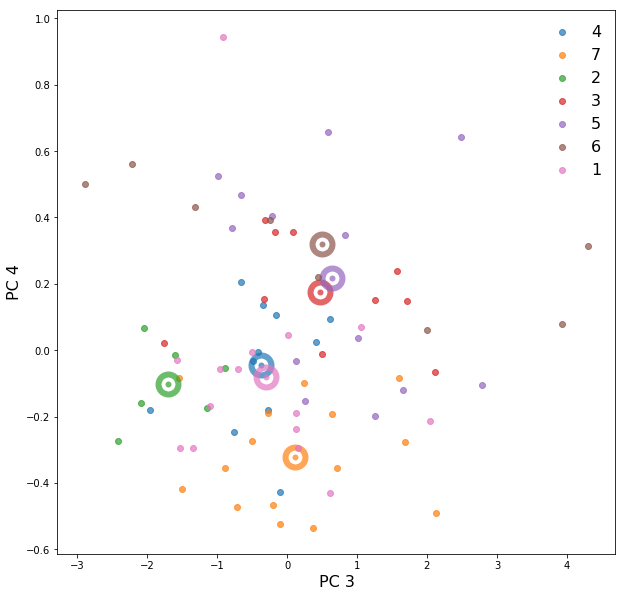

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


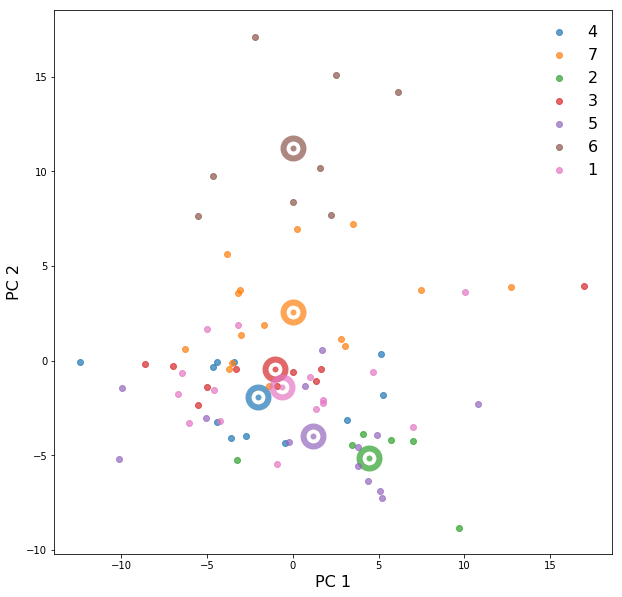

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


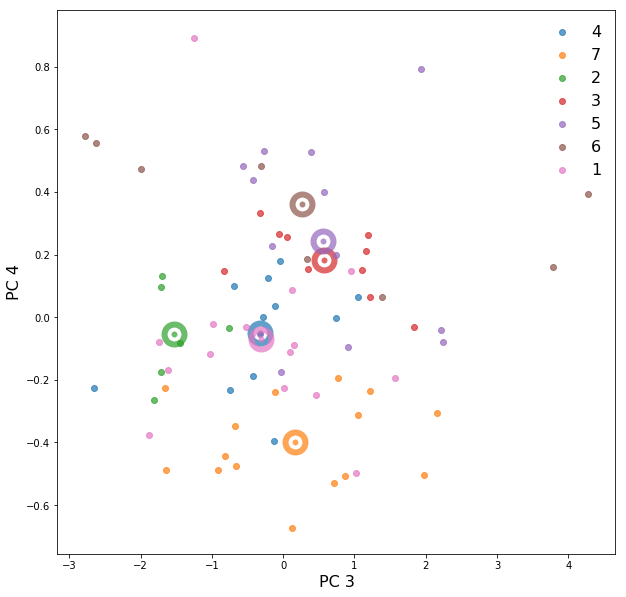

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


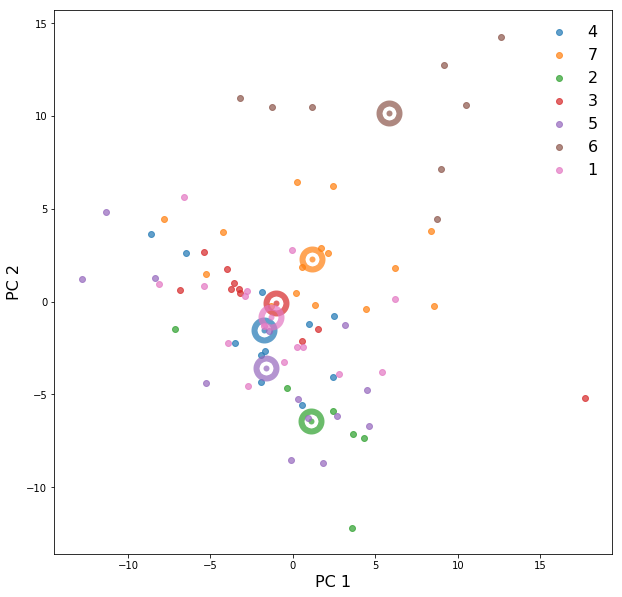

4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


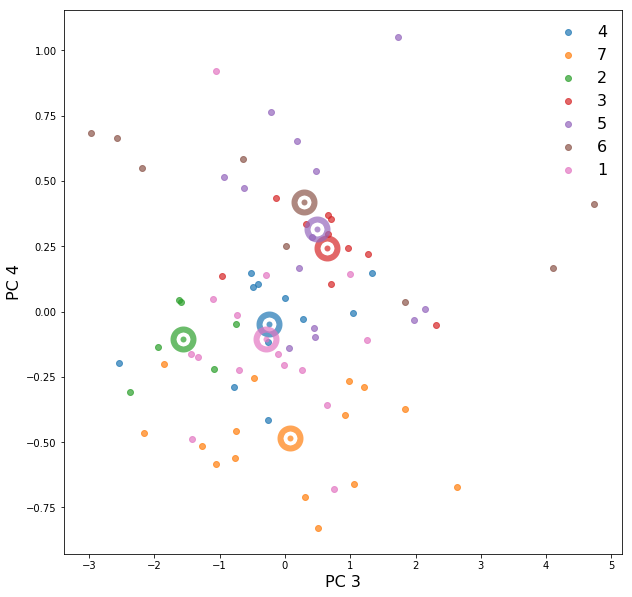

In [41]:
p_c_ids = list(path_dict.keys())

preds = []
infos = []
while len(infos) < 40001:
    print("%d" % len(infos), end="\r")
    c_ids = np.random.choice(p_c_ids, batch_size)
    ps = [path_dict[c_id] for c_id in c_ids]
    
    points, center_vertex_ids = pred.load_orphan_vertex_block_pychg(ps, n_points=n_points)
    p = pred.predict_points(model, points)
    
    for i_c_id in range(len(c_ids)):
        preds.append(p[i_c_id])
        infos.append([c_ids[i_c_id], 
                      center_vertex_ids[i_c_id]])
        
    if len(infos) % 10000 == 0:
        mean_infos = []
        mean_preds = []
        for u_id in np.unique(np.array(infos)[:, 0]):
            mean_infos.append([u_id])
            mean_preds.append(np.sum(np.array(preds)[np.array(infos)[:, 0] == u_id], axis=0))
            
        pca_plot_cell_types(np.array(mean_preds), np.array(mean_infos))

HIST FEATURES
4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


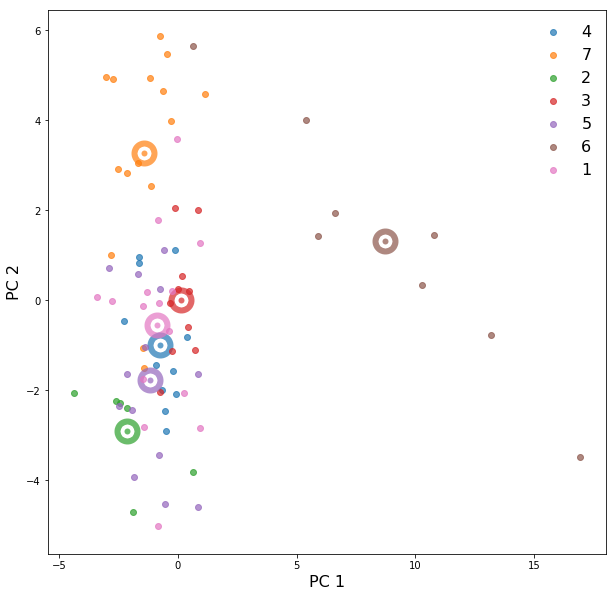

SIMPLE FEATURES
4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


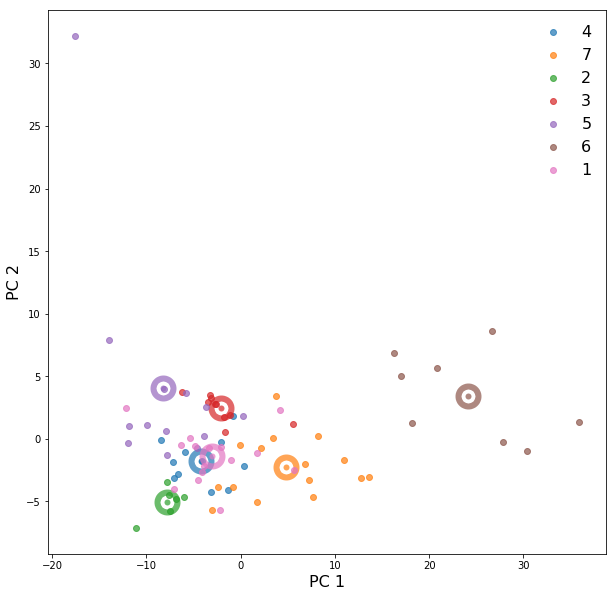

ALL FEATURES
4 11 11
7 15 17
2 6 6
3 10 10
5 13 14
6 8 8
1 15 15


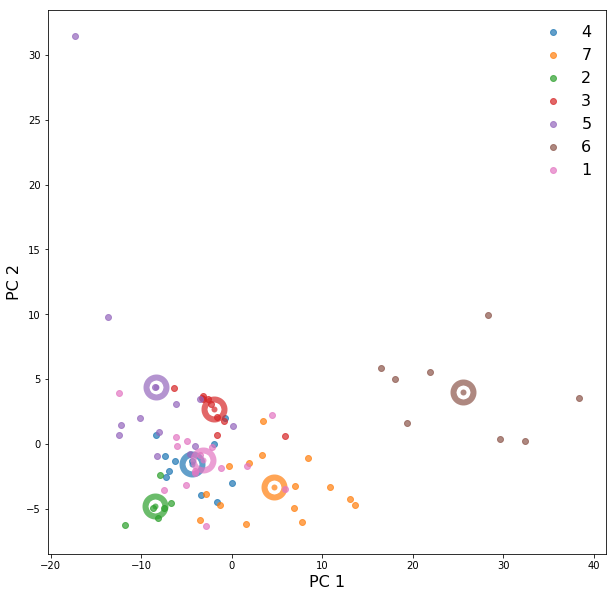

In [42]:
preds = np.array(preds)
infos = np.array(infos)
cell_ids = infos[:, 0]

u_cell_ids = np.unique(infos[:, 0])

n = np.max(preds)

def hist_1d(arr):
    return np.histogram(arr / arr.max(), bins=np.linspace(0, 1, 11))[0]

def feat_stats(arr):
    return np.concatenate([np.mean(arr, axis=0),
                           np.median(arr, axis=0),
                           np.var(arr, axis=0)])

feats_infos = []
feats = []
hist_feats = []

for u_id in np.unique(np.array(infos)[:, 0]):
#     if u_id in cell_type_exs["6"]:
#         continue
        
    feats_infos.append([u_id])
    
    m = np.array(infos)[:, 0] == u_id
    
    this_preds = preds[m]
    hist = np.apply_along_axis(hist_1d, axis=1, arr=this_preds)
    
    hist_feats.append(feat_stats(hist))
    feats.append(feat_stats(this_preds))

feats_infos = np.array(feats_infos)
hist_feats = np.array(hist_feats)
feats = np.array(feats)
all_feats = np.concatenate([hist_feats, feats], axis=1)
    
print("HIST FEATURES")
pca_plot_cell_types(hist_feats, feats_infos, plot_axis=[[0, 1]])

print("SIMPLE FEATURES")
pca_plot_cell_types(feats, feats_infos, plot_axis=[[0, 1]])

print("ALL FEATURES")
pca_plot_cell_types(all_feats, feats_infos, plot_axis=[[0, 1]])

## Prediction at synapses

In [21]:
syn_df = pd.read_csv(HOME + "/seungmount/research/Nick/zfish_synapse/remapping_edges/consensus-20180703/synapse_20180703__final.df")

In [22]:
syn_df['centroid_x'] *= 5
syn_df['centroid_y'] *= 5
syn_df['centroid_z'] *= 45

syns = np.array(syn_df[['presyn_segid', 'postsyn_segid', 'centroid_x', 'centroid_y', 'centroid_z']])
syns = syns[np.logical_and(~np.isnan(syns[:, 0]), ~np.isnan(syns[:, 1]))]

In [23]:
out_syn_dict = {}

blacklisted_out_ids = []
for cell_type in cell_type_exs.keys():
    for cell_id in cell_type_exs[cell_type]:
        out_syn_dict[cell_id] = syns[syns[:, 0] == cell_id][:, [2, 3, 4]]
        if len(out_syn_dict[cell_id]) == 0:
            print(cell_type, cell_id)
            blacklisted_out_ids.append(cell_id)

3 77128
5 77297
6 77483
6 77484
6 77486
6 77487
6 77488
6 77489
6 77490


In [24]:
in_syn_dict = {}

blacklisted_in_ids = []
for cell_type in cell_type_exs.keys():
    for cell_id in cell_type_exs[cell_type]:
        in_syn_dict[cell_id] = syns[syns[:, 1] == cell_id][:, [2, 3, 4]]
        if len(in_syn_dict[cell_id]) == 0:
            print(cell_type, cell_id)
            blacklisted_in_ids.append(cell_id)

5 77297
6 77483
6 77485
6 77487
6 77490


1 15 15
2 6 6
3 9 10
4 11 11
5 13 14
6 1 8
7 15 17


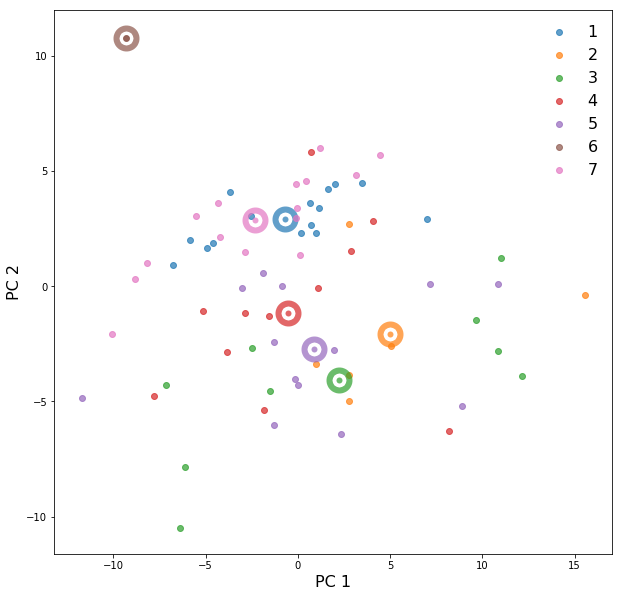

1 15 15
2 6 6
3 9 10
4 11 11
5 13 14
6 1 8
7 15 17


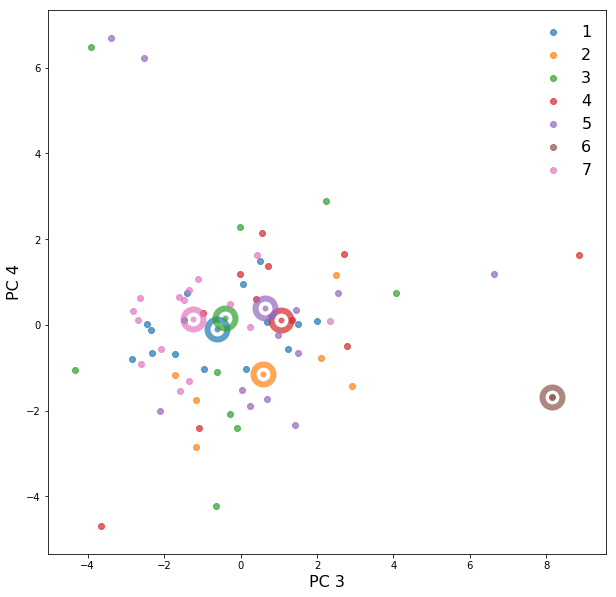

1 15 15
2 6 6
3 9 10
4 11 11
5 13 14
6 1 8
7 15 17


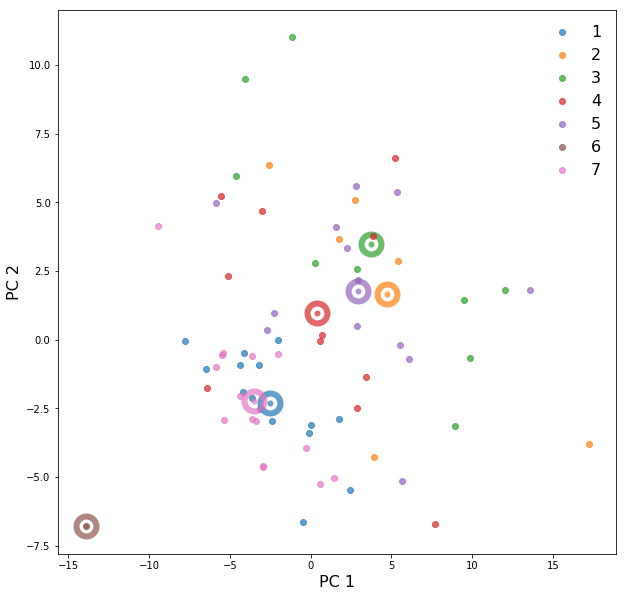

1 15 15
2 6 6
3 9 10
4 11 11
5 13 14
6 1 8
7 15 17


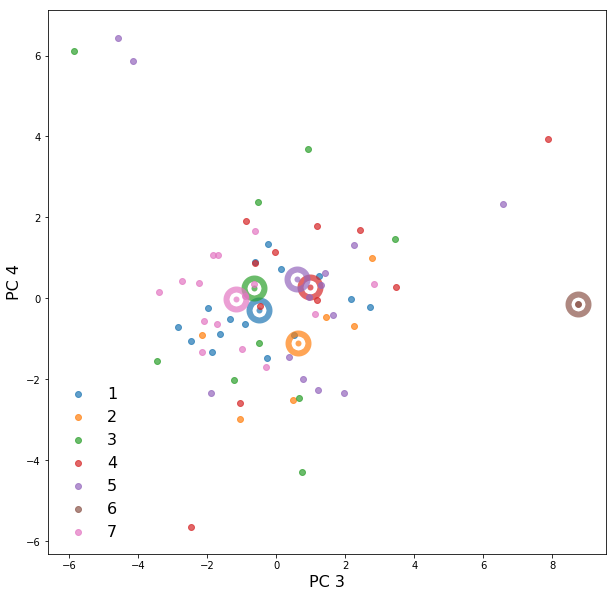

In [25]:
p_c_ids = np.array(list(path_dict.keys()))
p_c_ids = p_c_ids[~np.in1d(p_c_ids, blacklisted_out_ids)]

preds = []
infos = []
while len(infos) < 40001:
    print("%d" % len(infos), end="\r")
    c_ids = np.random.choice(p_c_ids, batch_size)
    ps = [path_dict[c_id] for c_id in c_ids]
    center_coords = [out_syn_dict[c_id][np.random.choice(len(out_syn_dict[c_id]), 1)][0] for c_id in c_ids]
    
    points, center_vertex_ids = pred.load_orphan_vertex_block_pychg(ps, n_points=n_points, center_coords=center_coords)
    p = pred.predict_points(model, points)
    
    for i_c_id in range(len(c_ids)):
        preds.append(p[i_c_id])
        infos.append([c_ids[i_c_id], center_vertex_ids[i_c_id]])
        
    if len(infos) % 20000 == 0:
        mean_infos = []
        mean_preds = []
        for u_id in np.unique(np.array(infos)[:, 0]):
            mean_infos.append([u_id])
            mean_preds.append(np.sum(np.array(preds)[np.array(infos)[:, 0] == u_id], axis=0))
            
        pca_plot(np.array(mean_preds), np.array(mean_infos))
#         pca_plot(np.array(preds), np.array(infos))

out_preds = np.array(preds).copy()
out_infos = np.array(infos).copy()

1 15 15
2 6 6
3 10 10
4 11 11
5 13 14
6 4 8
7 15 17


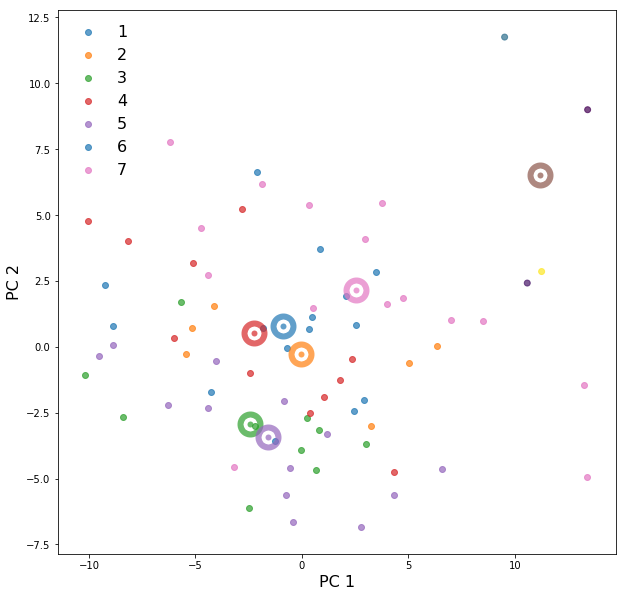

1 15 15
2 6 6
3 10 10
4 11 11
5 13 14
6 4 8
7 15 17


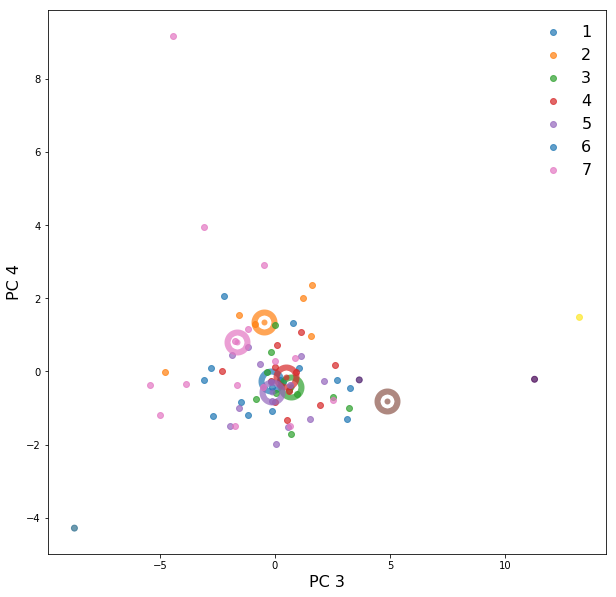

1 15 15
2 6 6
3 10 10
4 11 11
5 13 14
6 4 8
7 15 17


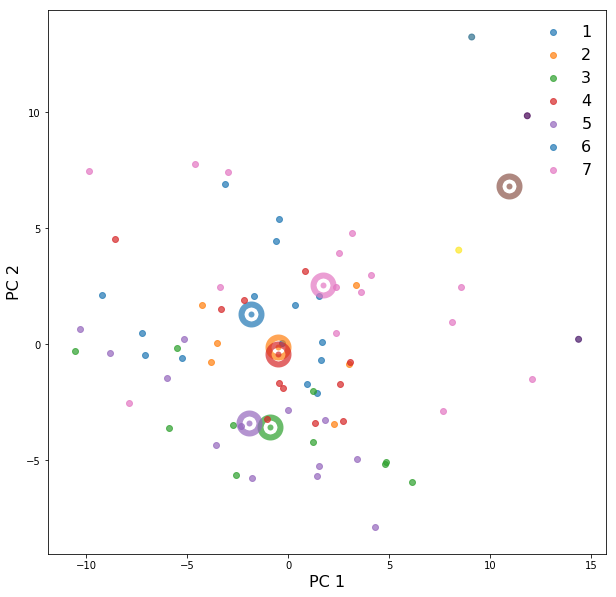

1 15 15
2 6 6
3 10 10
4 11 11
5 13 14
6 4 8
7 15 17


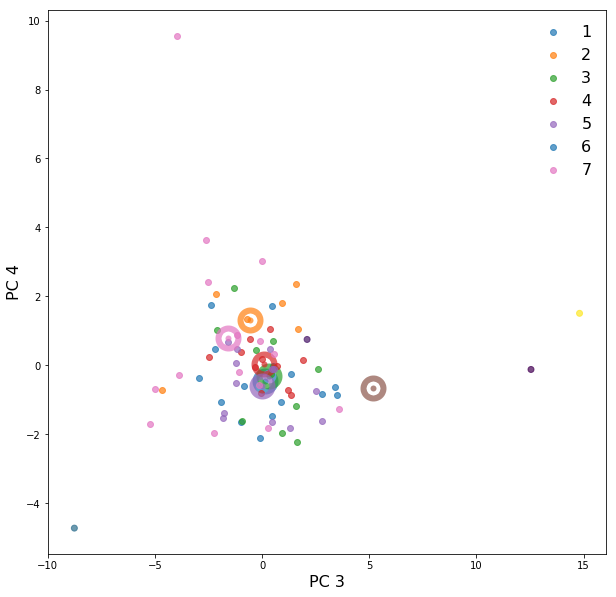

In [26]:
p_c_ids = np.array(list(path_dict.keys()))
p_c_ids = p_c_ids[~np.in1d(p_c_ids, blacklisted_in_ids)]

preds = []
infos = []
while len(infos) < 40001:
    print("%d" % len(infos), end="\r")
    c_ids = np.random.choice(p_c_ids, batch_size)
    ps = [path_dict[c_id] for c_id in c_ids]
    center_coords = [in_syn_dict[c_id][np.random.choice(len(in_syn_dict[c_id]), 1)][0] for c_id in c_ids]
    
    points, center_vertex_ids = pred.load_orphan_vertex_block_pychg(ps, n_points=n_points, center_coords=center_coords)
    p = pred.predict_points(model, points)
    
    for i_c_id in range(len(c_ids)):
        preds.append(p[i_c_id])
        infos.append([c_ids[i_c_id], center_vertex_ids[i_c_id]])
        
    if len(infos) % 20000 == 0:
        mean_infos = []
        mean_preds = []
        for u_id in np.unique(np.array(infos)[:, 0]):
            mean_infos.append([u_id])
            mean_preds.append(np.sum(np.array(preds)[np.array(infos)[:, 0] == u_id], axis=0))
            
        pca_plot(np.array(mean_preds), np.array(mean_infos))
#         pca_plot(np.array(preds), np.array(infos))

in_preds = np.array(preds).copy()
in_infos = np.array(infos).copy()

1 1000 15
2 1000 6
3 0 10
4 0 11
5 0 14
6 0 8
7 0 17


/usr/people/svenmd/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/people/svenmd/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


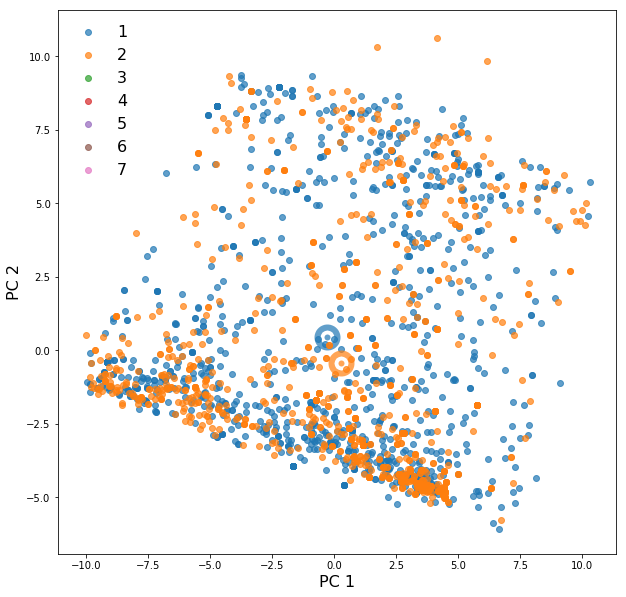

1 1000 15
2 1000 6
3 0 10
4 0 11
5 0 14
6 0 8
7 0 17


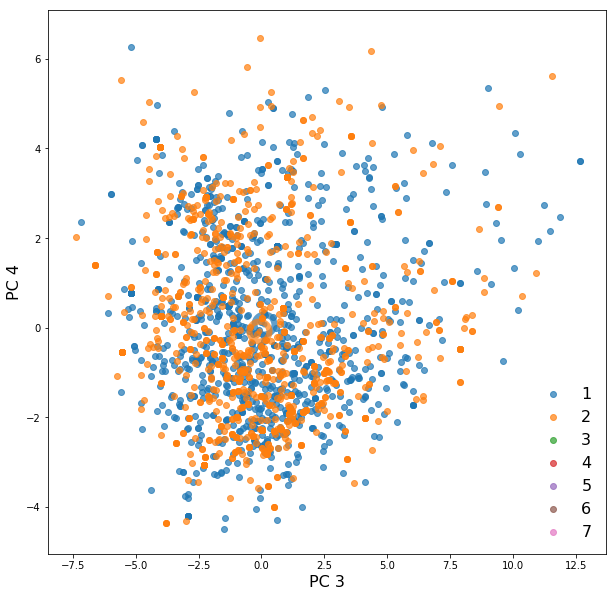

In [29]:
n_samples = 1000

in_out_pred = np.concatenate([in_preds[np.random.choice(len(in_preds), n_samples)], 
                              out_preds[np.random.choice(len(out_preds), n_samples)]])
in_out_info = np.concatenate([[[76631, None]] * n_samples, [[78046, None]] * n_samples])

pca_plot(in_out_pred, in_out_info)